# Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [30]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Recurrent Neurons and Layers 

Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer (a few exceptions are discussed in Appendix E). A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. Let’s look at the simplest possible RNN, composed of one neuron receiving inputs, producing an output, and sending that output back to itself, as shown in Figure 15-1 (left). At each time step $t$ (also called a frame), this recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y_{(t–1)}$. Since there is no previous output at the first time step, it is generally set to 0. We can represent this tiny network against the time axis, as shown in Figure 15-1 (right). This is called unrolling the network through time (it’s the same recurrent neuron represented once per time step).

<img src="./chapters/15/15-1.png">
<div style="text-align:center"> Figure 15-1. A recurrent neuron (left) unrolled through time (right) </div>  

You can easily create a layer of recurrent neurons. At each time step $t$, every neuron receives both the input vector $x(t)$ and the output vector from the previous time step $y_{(t–1)}$, as shown in Figure 15-2. Note that both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar). 

<img src="./chapters/15/15-2.png">
<div style="text-align:center"> Figure 15-2. A layer of recurrent neurons (left) unrolled through time (right) </div>  


Each recurrent neuron has two sets of weights: one for the inputs $x(t)$ and the other for the outputs of the previous time step, $y_{(t–1)}$. Let’s call these weight vectors $w_x$ and $w_y$. If we consider the whole recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices, $W_x$ and $W_y$. The output vector of the whole recurrent layer can then be computed pretty much as you might expect, as shown in Equation 15-1 ($b$ is the bias vector and $\phi(·)$ is the activation function (e.g., ReLU).

#### Equation 15-1. Output of a recurrent layer for a single instance
$$y_{(t)}=\phi\left(W_x^Tx_{(t)} + W_y^Ty_{(t-1)} + b\right)$$
Just as with feedforward neural networks, we can compute a recurrent layer’s output in one shot for a whole mini-batch by placing all the inputs at time step $t$ in an input matrix $X_{(t)}$ (see Equation 15-2).

#### Equation 15-2. Outputs of a layer of recurrent neurons for all instances in a mini-batch
$$\begin{align}
Y_{(t)}&=\phi\left(X_{(t)}W_x+Y_{(t-1)}W_y+b\right)\\
&=\phi\left(\begin{bmatrix}
X_{(t)} & Y_{(t-1)}
\end{bmatrix}W+b\right)\\
&\text{with } W=\begin{bmatrix}
W_x\\
W_y
\end{bmatrix}
\end{align}$$ 

In this equation:

- $Y_{(t)}$ is an $m \times n_{\text{neurons}}$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of instances in the mini-batch and $n_{\text{neurons}}$ is the number of neurons).

- $X_{(t)}$ is an $m \times n_{\text{inputs}}$ matrix containing the inputs for all instances ($n_{\text{inputs}}$ is the number of input features).

- $W_x$ is an $n_{\text{inputs}} \times n_{\text{neurons}}$ matrix containing the connection weights for the inputs of the current time step.

- $W_y$ is an $n_{\text{neurons}} × n_{\text{neurons}}$ matrix containing the connection weights for the outputs of the previous time step.

- $b$ is a vector of size $n_{\text{neurons}}$ containing each neuron’s bias term.

- The weight matrices $W_x$ and $W_y$ are often concatenated vertically into a single weight matrix $W$ of shape $(n_{\text{inputs}} + n_{\text{neurons}}) \times n_{\text{neurons}}$ (see the second line of Equation 15-2).

- The notation $\begin{bmatrix}
X_{(t)} & Y_{(t-1)}
\end{bmatrix}$ represents the horizontal concatenation of the matrices $X_{(t)}$ and $Y_{(t-1)}$.

Notice that $Y_{(t)}$ is a function of $X_{(t)}$ and $Y_{(t-1)}$, which is a function of $X_{(t-1)}$ and $Y_{(t-2)}$, which is a function of $X_{(t-2)}$ and $Y_{(t-3)}$, and so on. This makes $Y_{(t)}$ a function of all the inputs since time $t = 0$ (that is, $X_{(0)}, X_{(1)}, \cdots, X_{(t)}$). At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.

####  Memory Cells 


Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of memory. A part of a neural network that preserves some state across time steps is called a *memory cell* (or simply a cell). A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task). Later in this chapter, we will look at some more complex and powerful types of cells capable of learning longer patterns (roughly 10 times longer, but again, this depends on the task).

In general a cell’s state at time step $t$, denoted $h_{(t)}$ (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step: $h_{(t)} = f(h_{(t-1)}, x_{(t)}$). Its output at time step $t$, denoted $y_{(t)}$, is also a function of the previous state and the current inputs. In the case of the basic cells we have discussed so far, the output is simply equal to the state, but in more complex cells this is not always the case, as shown in Figure 15-3.


<img src="./chapters/15/15-3.png">
<div style="text-align:center"> Figure 15-3. A cell’s hidden state and its output may be different </div>  

#### Input and Output Sequences  

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see the top-left network in Figure 15-4). This type of *sequence-to-sequence network* is useful for predicting time series such as stock prices: you feed it the prices over the last N days, and it must output the prices shifted by one day into the future (i.e., from N – 1 days ago to tomorrow).

Alternatively, you could feed the network a sequence of inputs and ignore all outputs except for the last one (see the top-right network in Figure 15-4). In other words, this is a *sequence-to-vector network*. For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love]).

Conversely, you could feed the network the same input vector over and over again at each time step and let it output a sequence (see the bottom-left network of Figure 15-4). This is a *vector-to-sequence network*. For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image.

Lastly, you could have a *sequence-to-vector network*, called an **encoder**, followed by a *vector-to-sequence network*, called a **decoder** (see the bottom-right network of Figure 15-4). For example, this could be used for translating a sentence from one language to another. You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an Encoder–Decoder, works much better than trying to translate on the fly with a single sequence-to-sequence RNN (like the one represented at the top left): the last words of a sentence can affect the first words of the translation, so you need to wait until you have seen the whole sentence before translating it. We will see how to implement an Encoder–Decoder in Chapter 16 (as we will see, it is a bit more complex than in Figure 15-4 suggests). 


<img src="./chapters/15/15-4.png">
<div style="text-align:center"> Figure 15-4. Seq-to-seq (top left), seq-to-vector (top right), vector-to-seq (bottom left), and Encoder–Decoder (bottom right) networks </div> 

## Training RNNs  

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation (see Figure 15-5). This strategy is called *backpropagation through time* (BPTT).

Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a cost function $C(Y_{(0)}, Y_{(1)}, \cdots, Y_{(T)})$ (where $T$ is the max time step). Note that this cost function may ignore some outputs, as shown in Figure 15-5 (for example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one). The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows). Finally the model parameters are updated using the gradients computed during BPTT. Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output (for example, in Figure 15-5 the cost function is computed using the last three outputs of the network, $Y_{(2)}$, $Y_{(3)}$, and $Y_{(4)}$, so gradients flow through these three outputs, but not through $Y_{(0)}$ and $Y_{(1)}$). Moreover, since the same parameters $W$ and $b$ are used at each time step, backpropagation will do the right thing and sum over all time steps.  

<img src="./chapters/15/15-5.png">
<div style="text-align:center"> Figure 15-5. Backpropagation through time </div> 

## Forecasting a Time Series  

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company’s financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a *time series*. In the first two examples there is a single value per time step, so these are *univariate time series*, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a *multivariate time series*. A typical task is to predict future values, which is called forecasting. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called imputation. For example, Figure 15-6 shows 3 univariate time series, each of them 50 time steps long, and the goal here is to forecast the value at the next time step (represented by the big blue dots) for each of them. 

## Generate the Dataset

In [2]:
import numpy as np
np.random.rand(4, 3, 1)

array([[[0.62729121],
        [0.88428651],
        [0.93247076]],

       [[0.11358931],
        [0.61378714],
        [0.90584572]],

       [[0.17022974],
        [0.36935064],
        [0.02444864]],

       [[0.72904547],
        [0.73760726],
        [0.44899235]]])

In [4]:
freq1, freq2, offsets1, offsets2 = np.random.rand(4, 3, 1)
freq1, freq2, offsets1, offsets2

(array([[0.1734227 ],
        [0.75967117],
        [0.88893802]]),
 array([[0.43479005],
        [0.82423733],
        [0.7826524 ]]),
 array([[0.46835904],
        [0.89072677],
        [0.94038284]]),
 array([[0.83934674],
        [0.35189173],
        [0.72966474]]))

In [6]:
time = np.linspace(0, 1, 2) 
time

array([0., 1.])

In [7]:
time - offsets1 

array([[-0.46835904,  0.53164096],
       [-0.89072677,  0.10927323],
       [-0.94038284,  0.05961716]])

In [9]:
(time - offsets1) * (freq1)

array([[-0.08122409,  0.09219861],
       [-0.67665945,  0.08301172],
       [-0.83594207,  0.05299596]])

In [10]:
np.sin((time - offsets1) * (freq1))

array([[-0.08113481,  0.09206804],
       [-0.626192  ,  0.08291642],
       [-0.74192848,  0.05297115]])

In [14]:
np.sin((time - offsets1) * (freq1))[..., np.newaxis], np.sin((time - offsets1) * (freq1))[..., np.newaxis].shape

(array([[[-0.08113481],
         [ 0.09206804]],
 
        [[-0.626192  ],
         [ 0.08291642]],
 
        [[-0.74192848],
         [ 0.05297115]]]),
 (3, 2, 1))

In [17]:
np.sin((time - offsets1) * (freq1))[..., np.newaxis][:2, :1], np.sin((time - offsets1) * (freq1))[..., np.newaxis][:2, :1].shape

(array([[[-0.08113481]],
 
        [[-0.626192  ]]]),
 (2, 1, 1))

In [18]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # the freq1, freq2, offsets1, offsets2 are all batch_size X 1 arrays
    time = np.linspace(0, 1, n_steps) # time is n_steps X 1 array
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1, 
    #(time - offsets1) and (time - offsets1) * (freq1 * 10 + 10) are both batch_size X n_steps matrix
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2 , batch_size X n_steps matrix
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise, batch_size X n_steps matrix
    return series[..., np.newaxis].astype(np.float32) # return is batch_size X n_steps X 1 matrix

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1) # series is 10000 X 51 X 1 matrix
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # X_train is 7000 X 50 X 1 matrix
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [23]:
series.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((10000, 51, 1),
 (7000, 50, 1),
 (7000, 1),
 (2000, 50, 1),
 (2000, 1),
 (1000, 50, 1),
 (1000, 1))

In [28]:
X_valid[1, :, 0].shape, y_valid[0, 0], y_valid[1, 0], y_valid[2, 0]

((50,), 0.4000832, -0.50259125, 0.69304645)

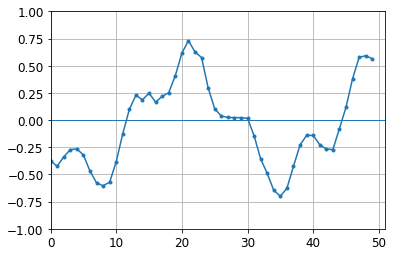

In [37]:
plt.plot(X_valid[0, :, 0], ".-")
plt.grid(True)
plt.hlines(0, 0, 100, linewidth=1)
plt.axis([0, 50 + 1, -1, 1])
plt.show()

Saving figure time_series_plot


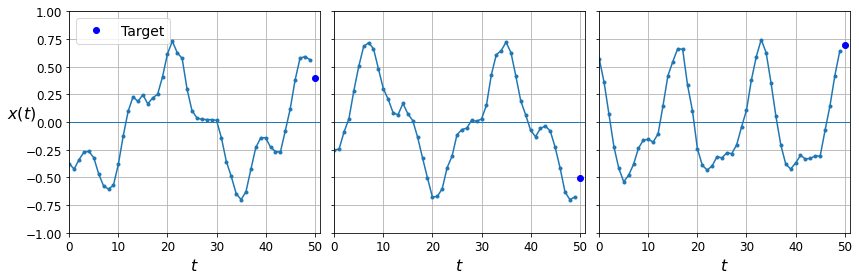

In [36]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**Figure 15-6. Time series forecasting**

## Computing Some Baselines

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called *naive forecasting*, and it is sometimes surprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

Naive predictions (just predict the last observed value):

In [42]:
X_valid, X_valid[:, -1], # [:, -1] get the 2000 bottom rows of each  50 X 1 matrix

(array([[[-0.3761855 ],
         [-0.42404684],
         [-0.3390344 ],
         ...,
         [ 0.5767727 ],
         [ 0.59239095],
         [ 0.5643068 ]],
 
        [[-0.2529655 ],
         [-0.24267727],
         [-0.08966523],
         ...,
         [-0.62975067],
         [-0.7007588 ],
         [-0.6759614 ]],
 
        [[ 0.57377684],
         [ 0.35977325],
         [ 0.06917338],
         ...,
         [ 0.14633761],
         [ 0.42088968],
         [ 0.64214784]],
 
        ...,
 
        [[ 0.19489938],
         [ 0.06072497],
         [-0.09699167],
         ...,
         [ 0.14607765],
         [-0.07222243],
         [-0.19055651]],
 
        [[-0.3360911 ],
         [-0.39338443],
         [-0.4867973 ],
         ...,
         [ 0.22584833],
         [-0.0463774 ],
         [-0.1811238 ]],
 
        [[ 0.5712927 ],
         [ 0.5462668 ],
         [ 0.3411039 ],
         ...,
         [-0.02652146],
         [ 0.18169478],
         [ 0.42333305]]], dtype=float32),
 arr

In [40]:
X_valid.shape, X_valid[:, -1].shape

((2000, 50, 1), (2000, 1))

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

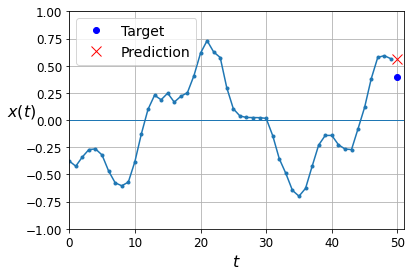

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [44]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7000, 50, 1), (7000, 1), (2000, 50, 1), (2000, 1))

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168086219578981

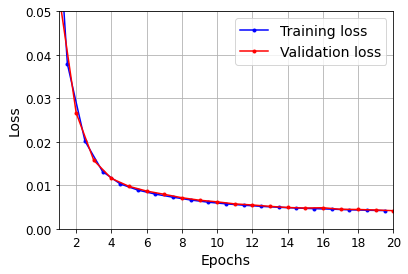

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

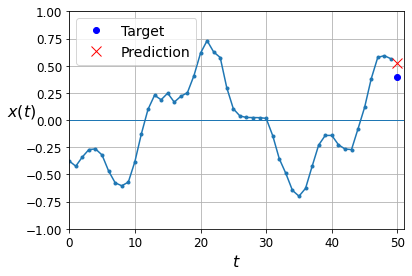

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 21s 96ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 21s 98ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 22s 98ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 22s 98ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 21s 98ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 22s 99ms/step - loss: 0.01

That’s really the simplest RNN you can build. It just contains a single layer, with a single neuron, as we saw in Figure 15-1. We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None). By default, the `SimpleRNN` layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: the initial state $h_{(\text{init})}$ is set to $0$, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_0$. In a simple RNN, this output is also the new state $h_0$. This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{49}$. All of this is performed simultaneously for every time series.

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0109


0.010881561785936356

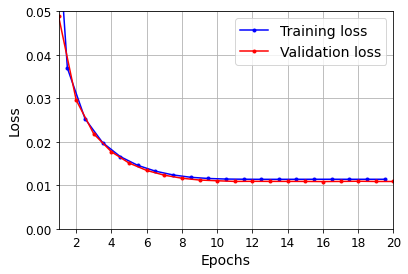

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

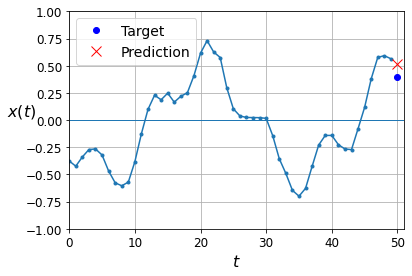

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

If you compile, fit, and evaluate this model (just like earlier, we train for 20 epochs using Adam), you will find that its MSE reaches only 0.01, so it is better than the naive approach but it does not beat a simple linear model. Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.

## Deep RNNs  

It is quite common to stack multiple layers of cells, as shown in Figure 15-7. This gives you a deep RNN.

<img src="./chapters/15/15-7.png">
<div style="text-align:center"> Figure 15-7. Deep RNN (left) unrolled through time (right) </div>  

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set `return_sequences=True`, as we will see.  

Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 75s 335ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 73s 332ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 73s 332ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 73s 333ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 72s 329ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 72s 328ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 72s 329ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 72s 329ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 72s 331ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 72s 331ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 24ms/step - loss: 0.0029: 0s - loss: 0.00


0.0029105590656399727

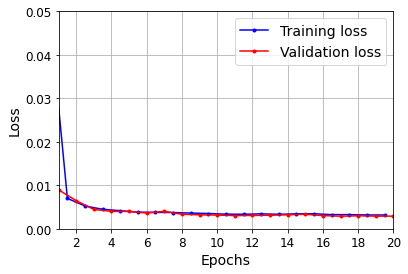

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

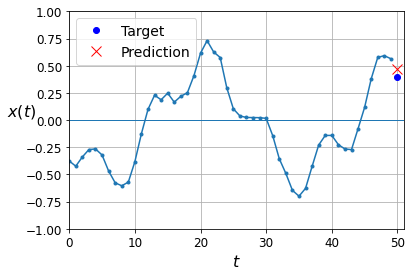

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much. Moreover, since a `SimpleRNN` layer uses the `tanh` activation function by default, the predicted values must lie within the range –1 to 1. But what if you want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If you make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer: 

Make the second `SimpleRNN` layer return only the last output:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 46s 208ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 47s 213ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 47s 215ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 47s 213ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 47s 213ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 47s 216ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 48s 217ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 47s 214ms/step - l

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 17ms/step - loss: 0.0026


0.002623624401167035

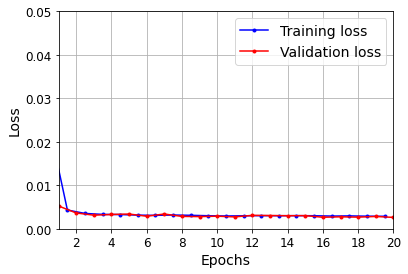

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

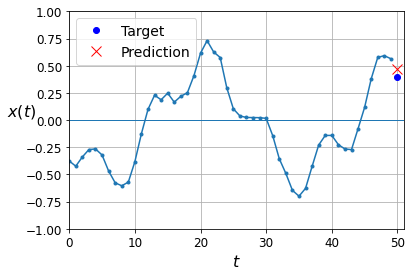

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead 

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately (e.g., to predict 10 steps ahead, just change the targets to be the value 10 steps ahead instead of 1 step ahead). But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on, as in the following code:

In [52]:
n_steps

50

In [46]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

In [50]:
X_new.shape, Y_new.shape, X_new[:, 1:].shape

((1, 50, 1), (1, 10, 1), (1, 49, 1))

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


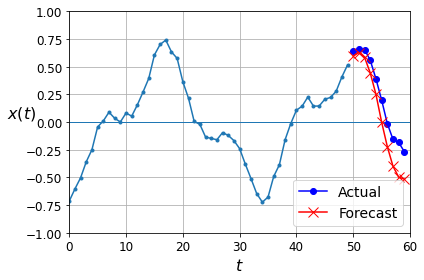

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [53]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [54]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((7000, 50, 1),
 (7000, 10),
 (2000, 50, 1),
 (2000, 10),
 (1000, 50, 1),
 (1000, 10))

Now let's predict the next 10 values one by one:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [31]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0222

Now let's create an RNN that predicts all 10 next values at once:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 47s 210ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 46s 208ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 47s 214ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 45s 206ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 45s 206ms/step - l

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

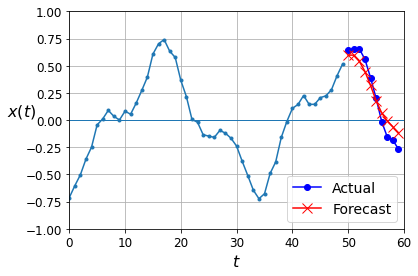

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

This model works nicely: the MSE for the next 10 time steps is about 0.008. That’s much better than the linear model. But we can still do better: indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [9]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [10]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between `X_train` and `Y_train`). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a causal model. 

To turn the model into a sequence-to-sequence model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step. Keras offers a `TimeDistributed` layer for this very purpose: it wraps any layer (e.g., a `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from [batch size, time steps, input dimensions] to [batch size × time steps, input dimensions]; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units), then it runs the Dense layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from [batch size × time steps, output dimensions] to [batch size, time steps, output dimensions]; in this example the number of output dimensions is 10, since the Dense layer has 10 units).2 Here is the updated model:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

The Dense layer actually supports sequences as inputs (and even higher-dimensional inputs): it handles them just like `TimeDistributed(Dense(…)`), meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer with just `Dense(10)`. For the sake of clarity, however, we will keep using `TimeDistributed(Dense(10))` because it makes it clear that the Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the `MSE` over all the outputs for training, we will use a custom metric for evaluation, to only compute the `MSE` over the output at the last time step:

In [38]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 47s 210ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 48s 221ms/step - loss: 0.0328 - last_time_step_mse: 0.0217 - val_loss: 0.0304 - val_last_time_step_mse: 0.0195
Epoch 4/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0295 - last_time_step_mse: 0.0182 - val_loss: 0.0277 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0273 - last_time_step_mse: 0.0154 - val_loss: 0.0254 - val_last_time_step_mse: 0.0138
Epoch 6/20
219/219 [==============================] - 46s 212ms/step - loss: 0.0249 - last_time_step_mse: 0.0122 - val_loss: 0.0229 - val_last_time_step_mse: 0.0097
Epoch 7/20

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

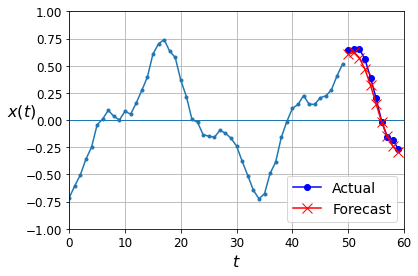

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

We get a validation MSE of about 0.006, which is 25% better than the previous model. You can combine this approach with the first one: just predict the next 10 values using this RNN, then concatenate these values to the input time series and use the model again to predict the next 10 values, and repeat the process as many times as needed. With this approach, you can generate arbitrarily long sequences. It may not be very accurate for long-term predictions, but it may be just fine if your goal is to generate original music or text, as we will see in Chapter 16.

## Handling Long Sequences  

To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence. Let’s look at both these problems, starting with the unstable gradients problem.

####  Fighting the Unstable Gradients Problem 

Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those at the third, and so on until the outputs explode—and a nonsaturating activation function does not prevent that. You can reduce this risk by using a smaller learning rate, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default). In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g., using TensorBoard) and perhaps use Gradient Clipping.

Moreover, Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers. To be more precise, it is technically possible to add a BN layer to a memory cell (as we will see shortly) so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step). However, the same BN layer will be used at each time step, with the same parameters, regardless of the actual scale and offset of the inputs and hidden state. In practice, this does not yield good results, as was demonstrated by César Laurent et al. in a 2015 paper: the authors found that BN was slightly beneficial only when it was applied to the inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers (i.e., vertically in Figure 15-7), but not within recurrent layers (i.e., horizontally). In Keras this can be done simply by adding a `BatchNormalization` layer before each recurrent layer, but don’t expect too much from it.

Another form of normalization often works better with RNNs: `Layer Normalization`. This idea was introduced by Jimmy Lei Ba et al. in a 2016 paper: it is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the features dimension. One advantage is that it can compute the required statistics on the fly, at each time step, independently for each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. Like BN, Layer Normalization learns a scale and an offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and the hidden states.

Let’s use `tf.keras` to implement Layer Normalization within a simple memory cell. For this, we need to define a custom memory cell. It is just like a regular layer, except its `call()` method takes two arguments: the `inputs` at the current time step and the `hidden` states from the previous time step. Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors (e.g., an `LSTMCell` has a long-term state and a short-term state, as we will see shortly). A cell must also have a `state_size` attribute and an `output_size` attribute. In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell which will behave like a `SimpleRNNCell`, except it will also apply Layer Normalization at each time step:

### Deep RNN with Batch Norm

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 50s 222ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 47s 216ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 45s 207ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20

### Deep RNNs with Layer Norm

In [42]:
from tensorflow.keras.layers import LayerNormalization

In [43]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

The code is quite straightforward. Our `LNSimpleRNNCell` class inherits from the `keras.layers.Layer` class, just like any custom layer. The constructor takes the number of units and the desired activation function, and it sets the `state_size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function). Then the constructor creates the `LayerNormalization` layer, and finally it fetches the desired activation function. The `call()` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a `SimpleRNNCell`, the outputs are just equal to the hidden states: in other words, `new_states[0]` is equal to `outputs`, so we can safely ignore `new_states` in the rest of the `call()` method). Next, the `call()` method applies Layer Normalization, followed by the activation function. Finally, it returns the outputs twice (once as the outputs, and once as the new hidden states). To use this custom cell, all we need to do is create a `keras.layers.RNN` layer, passing it a cell instance:

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 113s 506ms/step - loss: 0.1592 - last_time_step_mse: 0.1522 - val_loss: 0.0735 - val_last_time_step_mse: 0.0623
Epoch 2/20
219/219 [==============================] - 110s 503ms/step - loss: 0.0636 - last_time_step_mse: 0.0500 - val_loss: 0.0565 - val_last_time_step_mse: 0.0411
Epoch 3/20
219/219 [==============================] - 110s 503ms/step - loss: 0.0532 - last_time_step_mse: 0.0371 - val_loss: 0.0505 - val_last_time_step_mse: 0.0331
Epoch 4/20
219/219 [==============================] - 114s 519ms/step - loss: 0.0472 - last_time_step_mse: 0.0315 - val_loss: 0.0445 - val_last_time_step_mse: 0.0295
Epoch 5/20
219/219 [==============================] - 111s 505ms/step - loss: 0.0426 - last_time_step_mse: 0.0272 - val_loss: 0.0412 - val_last_time_step_mse: 0.0256
Epoch 6/20
219/219 [==============================] - 134s 610ms/step - loss: 0.0390 - last_time_step_mse: 0.0241 - val_loss: 0.0371 - val_last_time_step_mse: 0.0215
Epoc

Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: all recurrent layers (except for `keras.layers.RNN`) and all cells provided by Keras have a dropout hyperparameter and a `recurrent_dropout` hyperparameter: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step). No need to create a custom cell to apply dropout at each time step in an RNN.

With these techniques, you can alleviate the unstable gradients problem and train an RNN much more efficiently.

### Creating a Custom RNN Class

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 118s 533ms/step - loss: 0.1600 - last_time_step_mse: 0.1536 - val_loss: 0.0734 - val_last_time_step_mse: 0.0615
Epoch 2/20
219/219 [==============================] - 115s 527ms/step - loss: 0.0636 - last_time_step_mse: 0.0497 - val_loss: 0.0566 - val_last_time_step_mse: 0.0422
Epoch 3/20
219/219 [==============================] - 117s 534ms/step - loss: 0.0533 - last_time_step_mse: 0.0378 - val_loss: 0.0506 - val_last_time_step_mse: 0.0343
Epoch 4/20
219/219 [==============================] - 115s 526ms/step - loss: 0.0476 - last_time_step_mse: 0.0315 - val_loss: 0.0447 - val_last_time_step_mse: 0.0293
Epoch 5/20
219/219 [==============================] - 115s 525ms/step - loss: 0.0433 - last_time_step_mse: 0.0277 - val_loss: 0.0421 - val_last_time_step_mse: 0.0262
Epoch 6/20
219/219 [==============================] - 115s 525ms/step - loss: 0.0399 - last_time_step_mse: 0.0247 - val_loss: 0.0382 - val_last_time_step_mse: 0.0227
Epoc

Now let’s look at how to deal with the short-term memory problem.  

### Tackling the Short-Term Memory Problem  


Due to the transformations that the data goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN’s state contains virtually no trace of the first inputs. This can be a showstopper. Imagine Dory the fish trying to translate a long sentence; by the time she’s finished reading it, she has no clue how it started. To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore. Let’s first look at the most popular of these **long-term memory** cells: the LSTM cell.



### LSTMs 

The `Long Short-Term Memory (LSTM)` cell was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber and gradually improved over the years by several researchers, such as Alex Graves, Haşim Sak, and Wojciech Zaremba. If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. In Keras, you can simply use the LSTM layer instead of the `SimpleRNN` layer:

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 12ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [48]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788684979081154, 0.008560805581510067]

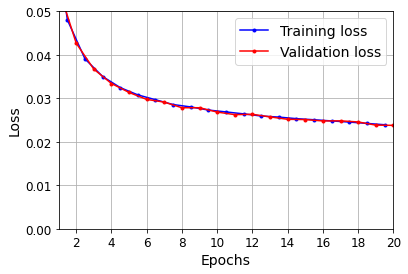

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

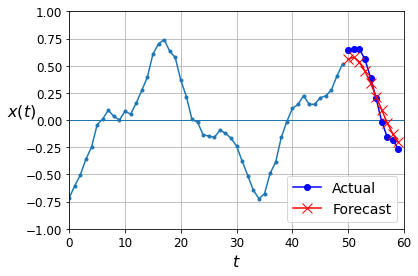

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Alternatively, you could use the general-purpose `keras.layers.RNN` layer, giving it an `LSTMCell` as an argument:

In [ ]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

However, the `LSTM` layer uses an optimized implementation when running on a GPU (see Chapter 19), so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier).

So how does an LSTM cell work? Its architecture is shown in Figure 15-9.

If you don’t look at what’s inside the box, the LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: $h_{(t)}$ and $c_{(t)}$ (“c” stands for “cell”). You can think of $h_{(t)}$ as the short-term state and $c_{(t)}$ as the long-term state. 


<img src="./chapters/15/15-9.png">
<div style="text-align:center"> Figure 15-9. LSTM cell </div>   



Now let’s open the box! The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it. As the long-term state $c_{(t–1)}$ traverses the network from left to right, you can see that it first goes through a forget gate, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an input gate). The result $c_{(t)}$ is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the `tanh` function, and then the result is filtered by the output gate. This produces the short-term state $h_{(t)}$ (which is equal to the cell’s output for this time step, $y_{(t)}$). Now let’s look at where new memories come from and how the gates work.

First, the current input vector $x_{(t)}$ and the previous short-term state $h_{(t–1)}$ are fed to four different fully connected layers. They all serve a different purpose: 

- The main layer is the one that outputs $g_{(t)}$. It has the usual role of analyzing the current inputs $x_{(t)}$ and the previous (short-term) state $h_{(t–1)}$. In a basic cell, there is nothing other than this layer, and its output goes straight out to $y_{(t)}$ and $h_{(t)}$. In contrast, in an LSTM cell this layer’s output does not go straight out, but instead its most important parts are stored in the long-term state (and the rest is dropped).

- The three other layers are gate controllers. Since they use the logistic activation function, their outputs range from 0 to 1. As you can see, their outputs are fed to element-wise multiplication operations, so if they output `0`s they close the gate, and if they output `1`s they open it. Specifically:

  - The forget gate (controlled by $f_{(t)}$) controls which parts of the long-term state should be erased.

  - The input gate (controlled by $i_{(t)}$) controls which parts of $g_{(t)}$ should be added to the long-term state.

  - Finally, the output gate (controlled by $o_{(t)}$) controls which parts of the long-term state should be read and output at this time step, both to $h_{(t)}$ and to $y_{(t)}$. 
  
In short, an LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

Equation 15-3 summarizes how to compute the cell’s long-term state, its short-term state, and its output at each time step for a single instance (the equations for a whole mini-batch are very similar).

Equation 15-3. LSTM computations 

$$\begin{align}
i_{(t)}&=\sigma(W_{xi}^Tx_{(t)}+W_{hi}^Th_{(t-1)}+b_i)\\
f_{(t)}&=\sigma(W_{xf}^Tx_{(t)}+W_{hf}^Th_{(t-1)}+b_f)\\
o_{(t)}&=\sigma(W_{xo}^Tx_{(t)}+W_{ho}^Th_{(t-1)}+b_o)\\
g_{(t)}&=tanh(W_{xg}^Tx_{(t)}+W_{hg}^Th_{(t-1)}+b_g)\\
c_{(t)}&=f_{(t)}\otimes c_{(t-1)}+i_{(t)}\otimes g_{(t)}\\
y_{(t)}&=h_{(t)}=o_{(t)}\otimes tanh(c_{(t)})\\
\end{align}$$ 

In this equation:

- $W_{xi}, W_{xf}, W_{xo}, W_{xg}$ are the weight matrices of each of the four layers for their connection to the input vector $x_{(t)}$.

- $W_{hi}, W_{hf}, W_{ho}, W_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $h_{(t-1)}$.

- $b_i, b_f, b_o, b_g$ are the bias terms for each of the four layers. Note that TensorFlow initializes $b_f$ to a vector full of $1$s instead of $0$s. This prevents forgetting everything at the beginning of training.


### PEEPHOLE CONNECTIONS  

In a regular LSTM cell, the gate controllers can look only at the input $x_{(t)}$ and the previous short-term state $h_{(t-1)}$. It may be a good idea to give them a bit more context by letting them peek at the long-term state as well. This idea was proposed by Felix Gers and Jürgen Schmidhuber in 2000. They proposed an LSTM variant with extra connections called **peephole connections**: the previous long-term state $c_{(t–1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate. This often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them: you will have to try it on your task and see if it helps.

In Keras, the LSTM layer is based on the `keras.layers.LSTMCell` cell, which does not support peepholes. The experimental `tf.keras.experimental.PeepholeLSTMCell` does, however, so you can create a `keras.layers.RNN` layer and pass a `PeepholeLSTMCell` to its constructor.

There are many other variants of the LSTM cell. One particularly popular variant is the GRU cell, which we will look at now.

### GRUs 

The **Gated Recurrent Unit (GRU)** cell (see Figure 15-10) was proposed by Kyunghyun Cho et al. in a 2014 paper that also introduced the Encoder–Decoder network we discussed earlier. 

<img src="./chapters/15/15-10.png">
<div style="text-align:center"> Figure 15-10. GRU cell </div> 

The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well (which explains its growing popularity). These are the main simplifications:

Both state vectors are merged into a single vector $h_{(t)}$.

A single gate controller $z_{(t)}$ controls both the forget gate and the input gate. If the gate controller outputs a $1$, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the LSTM cell in and of itself.

There is no output gate; the full state vector is output at every time step. However, there is a new gate controller $r_{(t)}$ that controls which part of the previous state will be shown to the main layer ($g_{(t)}$).

Equation 15-4 summarizes how to compute the cell’s state at each time step for a single instance. 

Equation 15-4. GRU computations 

$$\begin{align}
z_{(t)}&=\sigma(W_{xz}^Tx_{(t)}+W_{hz}^Th_{(t-1)}+b_z)\\
r_{(t)}&=\sigma(W_{xr}^Tx_{(t)}+W_{hr}^Th_{(t-1)}+b_r)\\
g_{(t)}&=tanh(W_{xg}^Tx_{(t)}+W_{hg}^T(r_{(t)}\otimes h_{(t-1)})+b_g)\\
h_{(t)}&=z_{(t)}\otimes h_{(t-1)}+(1-z_{(t)})\otimes g_{(t)}\\
\end{align}$$ 

Keras provides a `keras.layers.GRU` layer (based on the `keras.layers.GRUCell` memory cell); using it is just a matter of replacing `SimpleRNN` or `LSTM` with GRU.

LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. One way to solve this is to shorten the input sequences, for example using 1D convolutional layers.

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 12ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.0102628068998456]

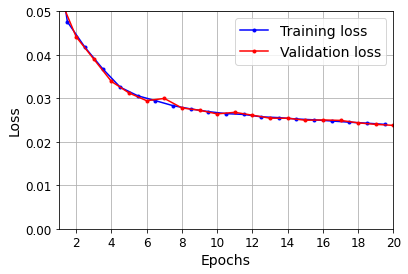

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

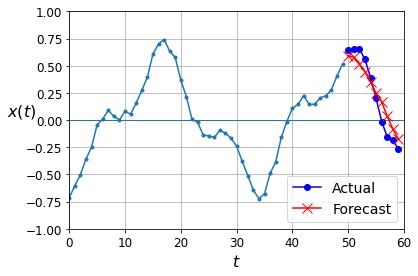

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### Using One-Dimensional Convolutional Layers to Process Sequences 

In Chapter 14, we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10-dimensional sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D `pooling` layers). If you use a 1D convolutional layer with a stride of `1` and "`same`" padding, then the output sequence will have the same length as the input sequence. But if you use "`valid`" padding or a stride greater than `1`, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly. For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of `2`, using a stride of `2`. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details. By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of `2`:

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20


If you train and evaluate this model, you will find that it is the best model so far. The convolutional layer really helps. In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!

### WaveNet 

In a 2016 paper, Aaron van den Oord and other DeepMind researchers introduced an architecture called *WaveNet*. They stacked 1D convolutional layers, doubling the dilation rate (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on (see Figure 15-11). This way, the lower layers learn short-term patterns, while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently. 

<img src="./chapters/15/15-11.png">
<div style="text-align:center"> Figure 15-11. WaveNet architecture </div> 

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In the WaveNet paper, the authors actually stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers. They justified this architecture by pointing out that a single stack of 10 convolutional layers with these dilation rates will act like a super-efficient convolutional layer with a kernel of size 1,024 (except way faster, more powerful, and using significantly fewer parameters), which is why they stacked 3 such blocks. They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network. Here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [1]:
for rate in (1, 2, 4, 8) * 2:
    print(rate)

1
2
4
8
1
2
4
8


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

This Sequential model starts with an explicit input layer (this is simpler than trying to set `input_shape` only on the first layer), then continues with a 1D convolutional layer using "`causal`" padding: this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of zeros on the left and using "`valid`" padding). We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function. Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the input sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them.

The last two models offer the best performance so far in forecasting our time series! In the WaveNet paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including text-to-speech tasks, producing incredibly realistic voices across several languages. They also used the model to generate music, one audio sample at a time. This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps—even LSTMs and GRUs cannot handle such long sequences.

In Chapter 16, we will continue to explore RNNs, and we will see how they can tackle various NLP tasks.

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [4]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [5]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

#### 1. Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?

Here are a few RNN applications:

- For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder–Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song

- For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of *collaborative filtering* for a recommender system)

- For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car’s camera)




#### 2. How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs? 

An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].

#### 3. If you want to build a deep sequence-to-sequence RNN, which RNN layers should have `return_sequences=True`? What about a sequence-to-vector RNN?

To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since False is the default).


#### 4. Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?

If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step $t$, the target should be a vector containing the values at time steps $t + 1$ to $t + 7$).


#### 5. What are the main difficulties when training RNNs? How can you handle them?

The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possibly use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use LSTM or GRU layers (this also helps with the unstable gradients problem).


#### 6. Can you sketch the LSTM cell’s architecture?

An LSTM cell’s architecture looks complicated, but it’s actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the `tanh` activation function). The new short-term state is equal to the output of the cell. See Figure 15-9.

#### 7. Why would you want to use 1D convolutional layers in an RNN?

An RNN layer is fundamentally sequential: in order to compute the outputs at time step $t$, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example by building a WaveNet architecture.


#### 8. Which neural network architecture could you use to classify videos?

To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a `softmax` layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

#### 9. Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets._

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [3]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065312256/1065301781 [==============================] - 131s 0us/step


In [4]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [5]:
train_files

['C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [6]:
eval_files

['C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\lidan\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [7]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [8]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [9]:
sorted(class_names)[:10]

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm']

In [10]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [11]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [12]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [13]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

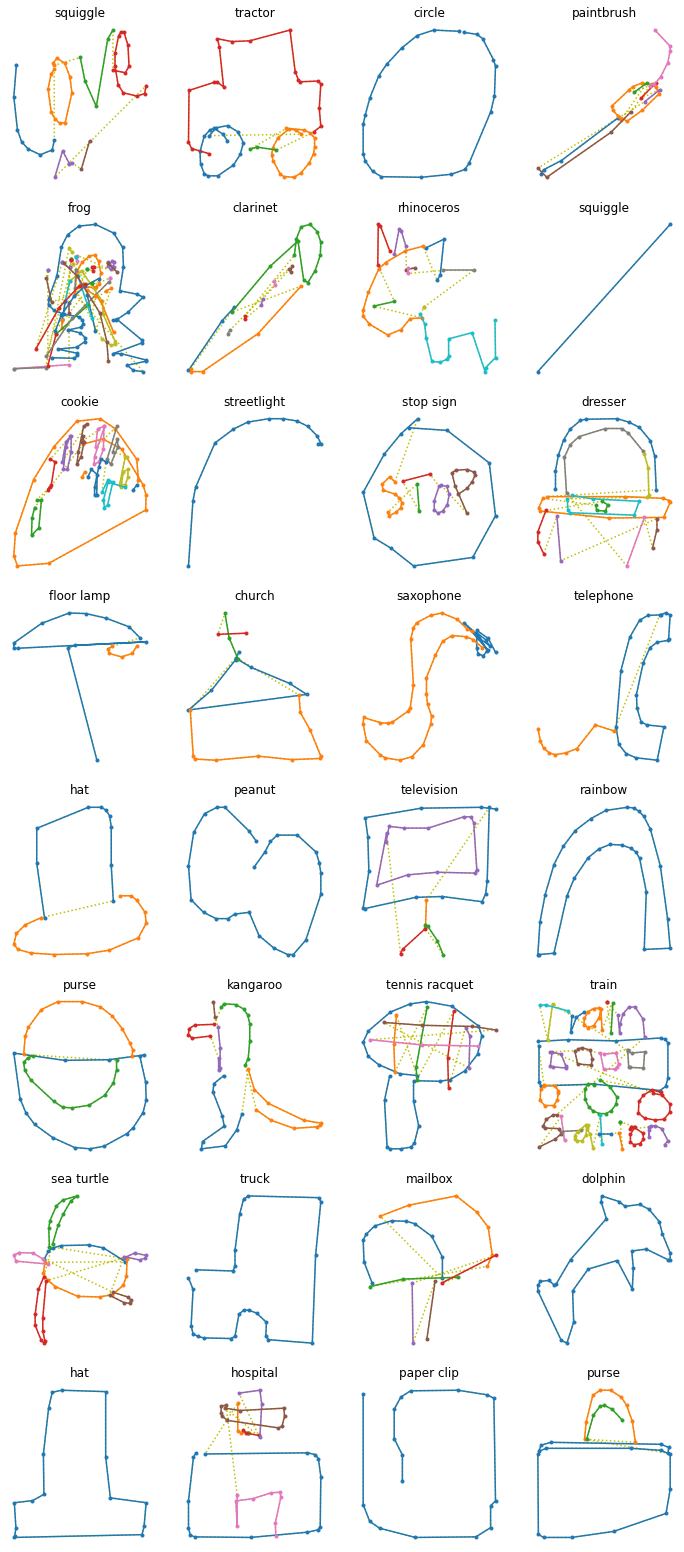

In [14]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

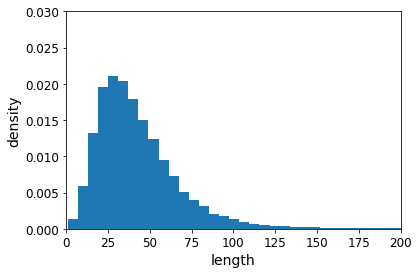

In [15]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [16]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2


In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn")


#### 10. Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out Google’s Coconet model, which was used for a nice Google doodle about Bach.

_Exercise: Download the [Bach chorales](https://homl.info/bach) dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google's Coconet model](https://homl.info/coconet), which was used for a nice [Google doodle about Bach](https://www.google.com/doodles/celebrating-johann-sebastian-bach)._



In [ ]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

Notes range from 36 (C1 = C on octave 1) to 81 (A5 = A on octave 5), plus 0 for silence:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

Let's write a few functions to listen to these chorales (you don't need to understand the details here, and in fact there are certainly simpler ways to do this, for example using MIDI players, but I just wanted to have a bit of fun writing a synthesizer):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Now let's listen to a few chorales:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Divine! :)

In order to be able to generate new chorales, we want to train a model that can predict the next chord given all the previous chords. If we naively try to predict the next chord in one shot, predicting all 4 notes at once, we run the risk of getting notes that don't go very well together (believe me, I tried). It's much better and simpler to predict one note at a time. So we will need to preprocess every chorale, turning each chord into an arpegio (i.e., a sequence of notes rather than notes played simultaneuously). So each chorale will be a long sequence of notes (rather than chords), and we can just train a model that can predict the next note given all the previous notes. We will use a sequence-to-sequence approach, where we feed a window to the neural net, and it tries to predict that same window shifted one time step into the future.

We will also shift the values so that they range from 0 to 46, where 0 represents silence, and values 1 to 46 represent notes 36 (C1) to 81 (A5).

And we will train the model on windows of 128 notes (i.e., 32 chords).

Since the dataset fits in memory, we could preprocess the chorales in RAM using any Python code we like, but I will demonstrate here how to do all the preprocessing using tf.data (there will be more details about creating windows using tf.data in the next chapter).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # predict next note in each arpegio, at each step
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # shift values
    return tf.reshape(window, [-1]) # convert to arpegio

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Now let's create the training set, the validation set and the test set:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

Now let's create the model:

* We could feed the note values directly to the model, as floats, but this would probably not give good results. Indeed, the relationships between notes are not that simple: for example, if you replace a C3 with a C4, the melody will still sound fine, even though these notes are 12 semi-tones apart (i.e., one octave). Conversely, if you replace a C3 with a C\#3, it's very likely that the chord will sound horrible, despite these notes being just next to each other. So we will use an `Embedding` layer to convert each note to a small vector representation (see Chapter 16 for more details on embeddings). We will use 5-dimensional embeddings, so the output of this first layer will have a shape of `[batch_size, window_size, 5]`.
* We will then feed this data to a small WaveNet-like neural network, composed of a stack of 4 `Conv1D` layers with doubling dilation rates. We will intersperse these layers with `BatchNormalization` layers for faster better convergence.
* Then one `LSTM` layer to try to capture long-term patterns.
* And finally a `Dense` layer to produce the final note probabilities. It will predict one probability for each chorale in the batch, for each time step, and for each possible note (including silence). So the output shape will be `[batch_size, window_size, 47]`.

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Now we're ready to compile and train the model!

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

I have not done much hyperparameter search, so feel free to iterate on this model now and try to optimize it. For example, you could try removing the `LSTM` layer and replacing it with `Conv1D` layers. You could also play with the number of layers, the learning rate, the optimizer, and so on.

Once you're satisfied with the performance of the model on the validation set, you can save it and evaluate it one last time on the test set:

In [ ]:
model.save("my_bach_model.h5")
model.evaluate(test_set)

**Note:** There's no real need for a test set in this exercise, since we will perform the final evaluation by just listening to the music produced by the model. So if you want, you can add the test set to the train set, and train the model again, hopefully getting a slightly better model.

Now let's write a function that will generate a new chorale. We will give it a few seed chords, it will convert them to arpegios (the format expected by the model), and use the model to predict the next note, then the next, and so on. In the end, it will group the notes 4 by 4 to create chords again, and return the resulting chorale.

**Warning**: `model.predict_classes(X)` is deprecated. It is replaced with `np.argmax(model.predict(X), axis=-1)`.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            #next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

To test this function, we need some seed chords. Let's use the first 8 chords of one of the test chorales (it's actually just 2 different chords, each played 4 times):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

Now we are ready to generate our first chorale! Let's ask the function to generate 56 more chords, for a total of 64 chords, i.e., 16 bars (assuming 4 chords per bar, i.e., a 4/4 signature):

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

This approach has one major flaw: it is often too conservative. Indeed, the model will not take any risk, it will always choose the note with the highest score, and since repeating the previous note generally sounds good enough, it's the least risky option, so the algorithm will tend to make notes last longer and longer. Pretty boring. Plus, if you run the model multiple times, it will always generate the same melody.

So let's spice things up a bit! Instead of always picking the note with the highest score, we will pick the next note randomly, according to the predicted probabilities. For example, if the model predicts a C3 with 75% probability, and a G3 with a 25% probability, then we will pick one of these two notes randomly, with these probabilities. We will also add a `temperature` parameter that will control how "hot" (i.e., daring) we want the system to feel. A high temperature will bring the predicted probabilities closer together, reducing the probability of the likely notes and increasing the probability of the unlikely ones.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

Let's generate 3 chorales using this new function: one cold, one medium, and one hot (feel free to experiment with other seeds, lengths and temperatures). The code saves each chorale to a separate file. You can run these cells over an over again until you generate a masterpiece!

**Please share your most beautiful generated chorale with me on Twitter @aureliengeron, I would really appreciate it! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

Lastly, you can try a fun social experiment: send your friends a few of your favorite generated chorales, plus the real chorale, and ask them to guess which one is the real one!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")